In [1]:
# Visualization of stopping criterion

import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import madmom
import mir_eval
from sklearn.model_selection import KFold

from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from modules.analysis_funcs import get_idx_to_fold, get_segmented_data, get_test_peaks, aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate
from modules.energy_based import legato_mg

%load_ext autoreload
%autoreload 2

FPS = 100
CONTEXT = 7

# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds2 = Dataset("slurtest_add_2")
ds3 = Dataset("slurtest_test")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths() + ds2.get_audio_paths() + ds3.get_audio_paths() 
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths() + ds2.get_annotation_paths() + ds3.get_annotation_paths() 

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [49]:
# Dataset info
audio_lengths_sec = [len(audio)/sr for audio,sr in zip(audios, sample_rates)]
iois = [np.ediff1d(onsets) for onsets in onset_schedules]
ioi_spreads = [np.std(np.ediff1d(onsets)) for onsets in onset_schedules]
onset_number = [len(onsets) for onsets in onset_schedules]
mean_ioi = np.sum([np.sum(ioi) for ioi in iois])/np.sum(onset_number)

print(len(iois))
print(np.sum(audio_lengths_sec)//60, int(np.sum(audio_lengths_sec)%60))
print(np.sum(onset_number))
print(np.mean(audio_lengths_sec))
print(mean_ioi*1000)

49
30.0 51
4642
37.79582422543847
363.29320788453253


In [4]:
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = list(kf.split(np.arange(len(audio_fnames))))

In [5]:
base_path = "results/cnn-training-220426/"
folds_path = base_path + "folds.pkl"

model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"

folds = kf_gen
#with open(folds_path, "rb") as f:
    #folds = pickle.load(f)

itf = get_idx_to_fold(folds)

neural = False
TOL = 0.025

epochs = np.arange(10,91,10)

test_idx = np.arange(36,40)

In [8]:
fss = []
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))
TOLS = np.arange(0.01,0.06,0.01)
for TOL in TOLS:
    fs = []
    rs = []
    ps = []
    CD_list = []
    FN_list = []
    FP_list = []
    for r in test_idx:
        rec_name = os.path.basename(audio_fnames[r])
        x = get_segmented_data(audio_fnames[r])
        out = model.predict(x)
        peaks = get_test_peaks(out, 1./FPS)
        [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
        CD_list.append(CD)
        FN_list.append(FN)
        FP_list.append(FP)
        scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        #print(scores["F-measure"], scores["Recall"], scores["Precision"])
        fs.append(scores["F-measure"])
        ps.append(scores["Precision"])
        rs.append(scores["Recall"])
    print("Mean F: ", np.mean(fs))
    #print("Mean P: ", np.mean(ps))
    #print("Mean R: ", np.mean(rs))
    fss.append(np.mean(fs))

/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Mean F:  0.587875914891238


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Mean F:  0.8167438324500284


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Mean F:  0.886122188936979


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Mean F:  0.9034226100348686


/home/simonf/.venv/onsets/lib/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Mean F:  0.9101585955683225


In [9]:
np.save(file="results/computed/cnn_time_prec.npy", arr=fss)

In [28]:
print("Total F: ", np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list))))
print("Total P: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FP_list)))
print("Total R: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FN_list)))

Total F:  0.8707692307692307
Total P:  0.8348082595870207
Total R:  0.909967845659164


In [17]:
av_scores = np.load("results/computed/av_scores.npy")
tot_scores = np.load("results/computed/tot_scores.npy")

In [23]:
av_scores_table = pd.DataFrame(
    [[av_scores[i//3,i%3,j] for j in range(3)] for i in range(6)],
    columns=["normal", "finetune", "extend"],
    index=[['ReLU', 'ReLU', 'ReLU', 'tanh', 'tanh', 'tanh', ], [0,0.3,0.5,0,0.3,0.5]])

            normal  finetune    extend
ReLU 0.0  0.696238  0.832404  0.635021
     0.3  0.831203  0.836871  0.424196
     0.5  0.805537  0.843265  0.263484
tanh 0.0  0.676864  0.714302  0.757311
     0.3  0.886968  0.878577  0.695480
     0.5  0.862003  0.861501  0.602996


In [7]:
CD_list = []
FN_list = []
FP_list = []
for r in range(len(itf.keys())):
    fold = itf[r]
    rec_name = os.path.basename(audio_fnames[r])
    x = get_segmented_data(audio_fnames[r])

    model = tf.keras.models.load_model(base_path + "fold_" + str(fold) + "_" + model_name + "_model")
    out = model.predict(x)
    peaks = get_test_peaks(out, 1./FPS)
    
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
    CD_list.append(CD)
    FN_list.append(FN)
    FP_list.append(FP)

    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    print(rec_name + "\t" + "F-score: {:.2f}".format(100*scores["F-measure"]))



In [23]:
# Only first fold
#model = tf.keras.models.load_model("results/cnn-training-220409/fold_0_added-seq-gen-nostandard_model")
av_scores = []
for r in folds[0][1]:
    rec_name = os.path.basename(audio_fnames[r])
    sig = madmom.audio.Signal(audio_fnames[r])
    spect = madmom.audio.spectrogram.Spectrogram(audio_fnames[r])
    hfc = madmom.features.onsets.high_frequency_content(spect)
    onehot, out = aubio_peakpicker_do(hfc, threshold=0.15)
    peaks = aubio_postprocessing(onehot, sig, db_thres=-90, min_ioi_frames=6)/FPS
    
    #x = get_segmented_data(audio_fnames[r])
    #out = model.predict(x)
    #peaks = get_test_peaks(out, 1./FPS)
    scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    print(scores["F-measure"]*100)
    av_scores.append(scores["F-measure"])
print(np.mean(av_scores))

80.26315789473685
19.88950276243094
63.128491620111724
56.92307692307692
43.39622641509434
6.862745098039215
76.30057803468206
66.19718309859154
0.5162012023084546


In [9]:
base_path = "results/cnn-training-220425/"
model_name = "a-seq-50eps-lr0.0010-nostandard"
TOL = 0.025
epochs = np.arange(5,51,5)
f_at_ep = np.zeros((len(audios), len(epochs)))

random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = list(kf.split(np.arange(len(audio_fnames))))
folds = [[np.arange(19), np.arange(19,36)]]

CD_list = np.zeros((len(audios), len(epochs)))
FN_list = np.zeros((len(audios), len(epochs)))
FP_list = np.zeros((len(audios), len(epochs)))
for fold, (train_idx, test_idx) in enumerate(folds):
    print("----")
    print("Fold ", fold)
    
    fold_average = []
    for r in test_idx:
        rec_name = os.path.basename(audio_fnames[r])
        sig = madmom.audio.Signal(audio_fnames[r])
        x = get_segmented_data(audio_fnames[r])
        model = tf.keras.models.load_model(base_path + "fold_" + str(fold) + "_" + model_name + "_model")
        for cp_i, epoch in enumerate(epochs):
            model.load_weights(base_path + "fold_" + str(fold) + "_" + model_name + "_cp_{:04d}.ckpt".format(epoch))
            out = model.predict(x)
            peaks = get_test_peaks(out, 1./FPS)
            scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
            f_at_ep[r, cp_i] = scores["F-measure"]
        
            #[CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
            #CD_list[r,cp_i] += CD
            #FN_list[r,cp_i] += FN
            #FP_list[r,cp_i] += FP
        scores = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
        print(rec_name + "\t" + "F-score: {:.2f}".format(100*scores["F-measure"]))
        #fold_average.append(scores["F-measure"])
    #print("Fold {}    average F-score {:.2f}".format(fold, 100*np.mean(fold_average)))
    #print()

----
Fold  0


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
2022-05-18 13:17:02.903407: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


stormhatten_IR2.wav	F-score: 83.60
slurtest02_IR1.wav	F-score: 91.73
slurtest01_IR2.wav	F-score: 89.55
slurtest03_FK1.wav	F-score: 90.23
6xtpsg_220319.wav	F-score: 80.65
slurtest04_IR2.wav	F-score: 92.31
melodyvib_220319.wav	F-score: 61.70
slurtest09_IR2.wav	F-score: 87.07
janissa_IR2.wav	F-score: 74.42
6xtpsg_220306.wav	F-score: 76.24
slurtest01_FK1.wav	F-score: 86.36


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest04_FK1.wav	F-score: 92.31
slurtest01_IR1.wav	F-score: 90.62
63an_start_220306.wav	F-score: 83.53
slurtest08_FK1.wav	F-score: 98.95


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest03_IR1.wav	F-score: 86.52
stormhatten_IR1.wav	F-score: 87.87


In [32]:
np.save(file="results/computed/fff_5_to_50_A.npy", arr=fff)

Text(0, 0.5, 'F-score on validation set')

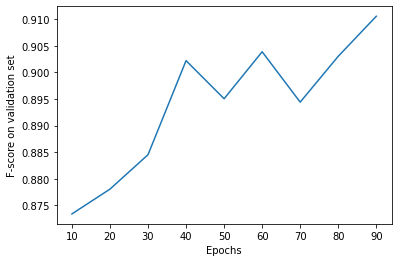

In [33]:
fff = np.sum(CD_list, 0)/(np.sum(CD_list, 0)+.5*(np.sum(FP_list, 0) + np.sum(FN_list, 0)))

import matplotlib.pyplot as plt
plt.plot(epochs,fff)
plt.xlabel("Epochs")
plt.ylabel("F-score on validation set")
#plt.scatter(35, np.max(fff))


In [ ]:
print("Total F: ", np.sum(CD_list)/(np.sum(CD_list)+.5*(np.sum(FP_list) + np.sum(FN_list))))
print("Total P: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FP_list)))
print("Total R: ", np.sum(CD_list)/(np.sum(CD_list)+np.sum(FN_list)))

In [3]:

np.load("results/computed/av_scores.npy")

(2, 3, 3)